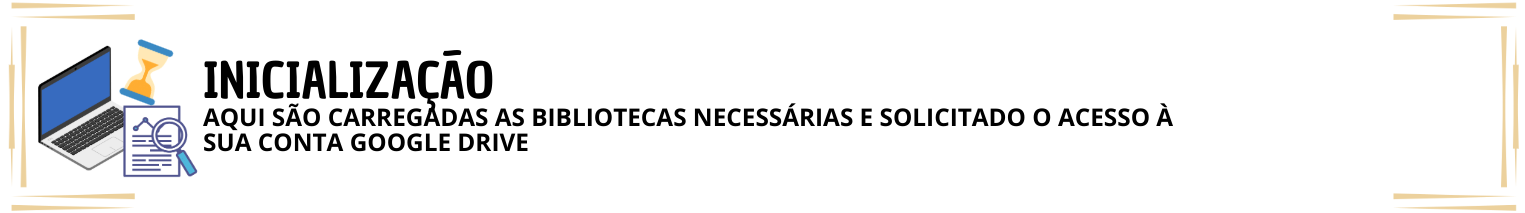

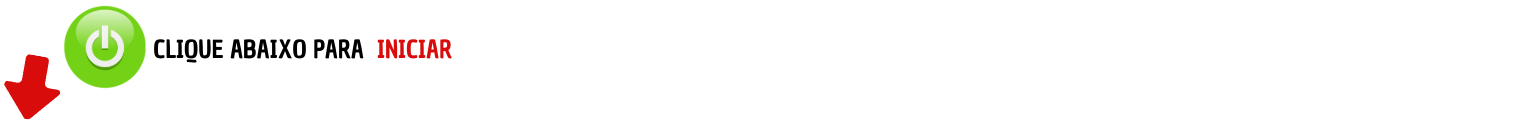

In [ ]:
# @title
!pip install pdfplumber
!pip install pyspark
!pip install google-generativeai
!pip install google.ai.generativelanguage
!pip install tabulate==0.9.0

# @title
import pdfplumber
import itertools
import pandas as pd
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content
from google.colab import files
from pyspark import SparkContext
import ast
import os
import re
import time
import datetime as dtm
import json
import tabulate as tb
from IPython.display import clear_output
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

clear_output()
print('BIBLIOTECAS CARREGADAS COM SUCESSO!')
time.sleep(3)
clear_output()

# Função para imprimir mensagem, dado um título (title) e uma string para a
# mensagem (msg). O parâmetro opcional 'delay', se informado, faz a mensagem
# desaparecer após o valor informado de 'delay' em segundos. Se 'title' for uma
# lista, cada valor representa o rótulo de uma coluna e 'msg' deve ser uma lista
# de listas, cada uma dessas listas uma linha (a mensagem toda será uma tabela)
def printMessage(msg, title, delay=0):
  if type(msg) is list:
    print(tb.tabulate(msg, headers=title, tablefmt='fancy_grid'))
  else:
    print(tb.tabulate([[msg]], headers=[title], tablefmt='fancy_grid'))
  if delay > 0:
    time.sleep(delay)
    clear_output()

# Tentando acesso à conta Google Drive...
try:
  if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

  DIR_PROJECT = '/content/drive/MyDrive/Colab Notebooks/DataHandler'

  # Verificando se existe a pasta do projeto. Se não existir, cria
  if os.path.isdir(DIR_PROJECT) == False:
    os.mkdir(DIR_PROJECT)
    # Movendo o arquivo DataHandler.ipynb recém uploaded para a pasta do projeto
    uploaded_file = '/content/drive/MyDrive/Colab Notebooks/DataHandler.ipynb'
    new_file = DIR_PROJECT + '/DataHandler.ipynb'
    os.rename(uploaded_file, new_file)

  # Verificando se existe a pasta de análise de dados. Se não exisitir, cria
  if not os.path.isdir(DIR_PROJECT + '/analysis'):
    os.mkdir(DIR_PROJECT + '/analysis')
except:
  print('Alguma instabilidade na rede não permitiu acesso ao Google Drive')
  print('Execute esta célula mais uma vez')

# Criando arquivo txt com chave de API Gemini, se não existir
try:
  if not os.path.exists(DIR_PROJECT + '/gemini-api-key.txt'):
    clear_output()
    msg = 'Você ainda não salvou a chave de API Gemini. Ela é necessária para que'
    msg += '\na aplicação funcione corretamente. Copie sua chave na página do Google'
    msg += '\nAI Studio em https://aistudio.google.com/app/u/1/apikey. Em seguida,'
    msg += '\ndigite ou cole logo abaixo'
    printMessage(msg, 'ATENÇÃO!')
    print('\n')
    key_gemini = input('Digite ou cole aqui sua chave do API Gemini: ')
    with open(DIR_PROJECT + '/gemini-api-key.txt', 'w') as f:
      f.write(key_gemini)
    msg = 'Chave de API Gemini salva com sucesso!'
    printMessage(msg, 'OPERAÇÃO CONCLUÍDA!', delay=4)
except KeyboardInterrupt:
  clear_output()
except Exception:
  pass

# Salvando o arquivo txt com o modelo de prompt da IA do Google, se ainda não
# foi feito
if not os.path.exists(DIR_PROJECT + '/gemini-model.txt'):
  try:
    !wget -P "$DIR_PROJECT" "https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/gemini-model.txt"
    clear_output()
  except Exception:
    title = 'ERRO NO CARREGAMENTO DO MODELO DE IA'
    msg = 'Ocorreu um erro na rede durante o carregamento do'
    msg += '\nmodelo de IA. Execute esta célula novamente caso'
    msg += '\ncontrário a ferramenta não funcionará\ncorretamente'
    printMessage(msg, title=title)

# Salvando o arquivo JSON com segmentos e seus códigos, se ainda não foi feito
if not os.path.exists(DIR_PROJECT + '/segmentos.json'):
  try:
    !wget -P "$DIR_PROJECT" "https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/segmentos.json"
    clear_output()
  except Exception:
    title = 'ERRO NO CARREGAMENTO DO MODELO DE IA'
    msg = 'Ocorreu um erro na rede durante o carregamento do'
    msg += '\nmodelo de IA. Execute esta célula novamente'
    printMessage(msg, title=title)

###############################################################################
#                      Definição da classe DataHandler
###############################################################################
class DataHandler:
  def __init__(self, dt=False, filename=None, coment=None):

    # Tamamanho do bloco de dados analisados de uma vez c/ IA p/ obter segmentos
    self.batch_size = 100

    # Tempo em segundos de pausa entre processamentos de blocos de dados
    self.batch_delay = 15

    # Número máximo de Tokens do modelo de IA
    self.max_tokens = 30000

    self.lista_result_gemini = list()

    # Carregando chave de API Gemini
    with open(DIR_PROJECT + '/gemini-api-key.txt', 'r') as f:
      genai.configure(api_key=f.read().strip())

    # Carregando modelo de prompt Gemini do arquivo txt
    with open(DIR_PROJECT + '/gemini-model.txt', 'r') as f:
      self.gemini_model = f.read()

    # Carregando dataframe com código/segmento do arquivo CSV
    self.segmentos_df = pd.read_json(DIR_PROJECT + '/segmentos.json')

    # String com data/hora não informada (novos dados). Criando nova string...
    if dt is False:
      dt_hr = dtm.datetime.now()
      lst_dt = str(dt_hr).split(' ')
      self.dt = lst_dt[0] + '|' + lst_dt[1]

      # DataFrame Pandas com todos os dados, se foi informado 'filename'
      self.filename = filename
      if filename is None:
        self.full_df = None
      else:
        self.full_df = self.miningDataInPDF()

      # DataFrame Pandas com todos os reprovados
      self.reprov_df = None

      # DataFrame c/ reprovados por segmento
      self.reprov_classif_df = None

      # Salvando comentário
      self.coment = coment

    # String com data/hora foi informado. Carregando dados em CSVs e txt...
    else:
      self.dt = dt
      # DataFrame Pandas com todos os dados
      try:
        self.full_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
      except Exception:
        self.full_df = None
      # DataFrame Pandas com todos os reprovados
      try:
        self.reprov_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')
      except Exception:
        self.reprov_df = None
      # DataFrame c/ reprovados por segmento
      try:
        self.reprov_classif_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')
      except Exception:
        self.reprov_classif_df = None

      self.filename = None

      try:
        self.coment = open(DIR_PROJECT + '/analysis/' + self.dt + '/coment.txt', 'r').read()
      except Exception:
        self.coment = ''

    # Verificando se a pasta dos dados já existe. Se não existir, cria
    if not os.path.isdir(DIR_PROJECT + '/analysis/' + self.dt):
      os.mkdir(DIR_PROJECT + '/analysis/' + self.dt)


  # df_name pode ser 'df_full', 'df_reprov', 'df_classif'
  def __existsDataFrame(self, df_name):
    match df_name:
      case 'df_full':
        try:
          self.df_full = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
          return True
        except FileNotFoundError:
          return False
      case 'df_reprov':
        try:
          self.df_reprov = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')
          return True
        except FileNotFoundError:
          return False
      case 'df_classif':
        try:
          self.df_classif = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')
          return True
        except FileNotFoundError:
          return False
      case _:
        return False

  # Retorna datas inicial e final dos dados brutos e monta label para gráfico de
  # Pareto com 'De ##/##/#### a ##/##/####'
  def __labelGraphDates(self):
    df = self.full_df['data'].apply(lambda x: dtm.datetime.strptime(x, '%d/%m/%y'))
    dt_ini = df.min().strftime('%d/%m/%Y')
    dt_fim = df.max().strftime('%d/%m/%Y')
    return dt_ini + ' a ' + dt_fim


  # Retorna DataFrame Pandas com todos os resultados de um PDF informado
  def miningDataInPDF(self, filename, coment):

    if self.__existsDataFrame('df_full'):
      return self.full_df
    else:
      # Extraindo páginas do PDF
      pgs = pdfplumber.open(filename).pages

      # Tabela temporária para usar no loop
      tb = None

      # DataFrame Pandas temporário para usar no loop com 12 colunas
      df_temp = pd.DataFrame()

      # DataFrame Pandas para todos os dados
      df = pd.DataFrame()

      # Lista com itens problemáticos encontrados na criação do DataFrame
      list_problems = list()

      list_data = list()

      # Gerando o DataFrame Pandas para todos os dados
      for pg in pgs:
        try:
          tb = pg.extract_table()
          list_data += tb[3:]
          df_temp = pd.DataFrame(tb[3:])
          df = pd.concat([df, df_temp])
        except Exception:
          pass

      # Definindo os rótulos do DataFrame Pandas final
      rotulos = [
          'laudo',
          'data',
          'resultado',
          'i',
          'm',
          'im',
          'produto',
          'tc',
          'marca',
          'qn',
          'quant',
          'aleat'
          ]

      # Selecionando apenas as 12 colunas que interessam
      df_dados_brutos = df.iloc[0:,0:12]

      # Definido cabeçalho do dataframe
      df_dados_brutos.columns = rotulos

      # Aplicando função lambda para tirar quebra de linha na coluna 'qn' (se
      # houver)
      try:
        df_dados_brutos['qn'] = df_dados_brutos['qn'].apply(lambda x: x.replace('\n', ' '))
      except Exception:
        pass

      # Eliminando linhas vazias e resetando os índices
      df_dados_brutos = df_dados_brutos.dropna().reset_index()

      # Salvando DataFrames na pasta do projeto como CSV
      self.full_df = df_dados_brutos
      self.reprov_df = self.full_df[self.full_df['resultado'] == 'Reprovado']

      # Salvando CSVs com dados brutos e com reprovados e txt com comentário
      self.__makeDirAnalysis()
      self.full_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
      self.reprov_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')
      with open(DIR_PROJECT + '/analysis/' + self.dt + '/coment.txt', 'w') as f:
        f.write(coment)

      return df_dados_brutos


  # # Retorna lista com tuplas (laudo, produto) dado um DataFrame com dados brutos
  # # A lista com tuplas retornada é que será utilizada pelo método classifyReprov()
  # # para classificar cada mercadoria reprovada quanto a seu segmento com IA
  # def __getListaTuplas(self, df):
  #   df_dados = df.iloc[0:, [1,7]]
  #   lista_dic = df_dados.to_dict('records')

  #   try:
  #     spark_cont = SparkContext()
  #   except Exception:
  #     pass

  #   rdd = spark_cont.parallelize(lista_dic)
  #   lista = rdd.map(lambda item: (item['laudo'], item['produto'])).collect()

  #   spark_cont.stop()

  #   return lista

  # Extrai de 'self.df_full' apenas as colunas 'laudo', 'produto' e 'qn'
  # adiciona os campos 'qn_ms', 'qn_vl', 'qn_un' e 'qn_cp' para os símbolos das
  # indicações de massa, volume, n.º de unidades e unidades de comprimento.
  # Depois transforma numa lista de dicionários excluindo a coluna 'qn'
  def getDictMercadorias(self):

    # Definindo um dataframe chamado 'df' com todos os reprovados
    df = self.reprov_df
    df = df.loc[:, ['laudo', 'produto']]

    # Convertendo os valores de laudo (string) para inteiro (int)
    try:
      df['laudo'] = df['laudo'].apply(lambda x: int(x))
    except Exception:
      pass

    # Retornando a lista de dicionários com os dados
    return df.to_dict('records')


  # Retorna DataFrame Pandas com todos os reprovados
  def reprovToDataFrame(self):
    if self.full_df is None:
      self.miningDataInPDF()
    df = self.full_df[self.full_df['resultado'] == 'Reprovado']
    df.reset_index(inplace=True, drop=True)
    self.reprov_df = df
    return df


  # Cria diretório para armazenar arquivos de análise de dados se não existir
  # Usar para salvar os DataFrames relevantes (PADRONIZAR NOMES)
  def __makeDirAnalysis(self):
    dt = self.dt
    if not os.path.isdir(DIR_PROJECT + '/analysis/' + dt):
      os.mkdir(DIR_PROJECT + '/analysis/' + dt)


  # Usa Gemini para retornar lista com pares de valores [laudo, codigo_segmento]
  # dada lista de dicionários com chaves 'laudo', 'produto', 'qn_ms', 'qn_vl',
  # 'qn_un' e 'qn_cp'
  def getSegmentosFromDicion(self, dicion):
    generation_config = {
      "temperature": 0.1,
      "top_k": 1,
      "top_p": 0.1,
      "max_output_tokens": self.max_tokens,
      "response_schema": content.Schema(
        type = content.Type.OBJECT,
        properties = {
          "response": content.Schema(
            type = content.Type.STRING,
          ),
        },
      ),
      "response_mime_type": "application/json",
    }

    model = genai.GenerativeModel(
      model_name="gemini-1.5-pro",
      generation_config=generation_config,
      system_instruction=self.gemini_model
    )

    chat_session = model.start_chat(
      history=[
        {
          "role": "user",
          "parts": [
            "[{'laudo': 694375, 'produto': 'CANJICA'}, 'laudo': 694379, 'produto': 'SOPÃO'}]",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[{\"laudo\": \"694375\", \"segmento\": 2}, {\"laudo\": \"694379\", \"segmento\": 2}]\n\n```",
          ],
        },
        {
          "role": "user",
          "parts": [
            "A resposta deve ser no seguinte formato : [ (694375, 2), (694379, 2) ]",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[[\"694375\", 2], [\"694379\", 2]]\n\n```",
          ],
        },
        {
          "role": "user",
          "parts": [
            "Produtos com nome semelhante a CORDA PARA VARAL, CANJICA, SOPÃO e COCO RALADO têm segmento igual a 0",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[[\"694375\", 0], [\"694379\", 0]]\n\n```",
          ],
        },
      ]
    )

    response = chat_session.send_message(str(dicion))

    self.lista_result_gemini.append(response.text) # Excluir depois

    try:
      lista = ast.literal_eval(response.text)['response']
      lista = ast.literal_eval(lista)
    except Exception:
      pass

    return lista


  # Classifica os reprovados por segmento com IA
  def classifyReprov(self):

    self.lista_result_gemini = []

    # Lista para receber os dados processados em cada iteração
    result = list()

    # Lista com todos os itens de 'result'
    lst_result = list()

    if self.__existsDataFrame('df_classif'):
      return self.reprov_classif_df
    else:
      # DataFrame com todos os reprovados para classificar
      dicion = self.getDictMercadorias()

      ################# Usando o modelo IA P/ estimar segmentos ################
      cota = self.batch_size
      if len(dicion) <= cota:
        str_dicion = str(dicion)
        response = self.getSegmentosFromDicion(str_dicion)
        result.append(response)
      else:
        qnt = len(dicion)
        resto = qnt % cota
        n_iteracoes = qnt // cota
        inicio = 0
        fim = cota
        for i in range(n_iteracoes):
          str_dicion = str(dicion[inicio:fim])
          response = self.getSegmentosFromDicion(str_dicion)
          result.append(response)
          inicio=fim
          fim+=cota
          time.sleep(self.batch_delay)
        fim = fim - cota + resto
        str_dicion = str(dicion[inicio:fim])
        response = self.getSegmentosFromDicion(str_dicion)
        result.append(response)

      # Unindo todas as listas de 'result' numa única lista
      lista_unica = list(itertools.chain.from_iterable(result))

      # Criando dataframe com os pares "n.º laudo"/"código segmento"
      df = pd.DataFrame(lista_unica, columns=['laudo', 'codigo'])

      # Dataframe com todos os reprovados
      df_rp = self.reprov_df

      # Dataframe com os valores código/segmento
      df_cod_seg = self.segmentos_df

      # Unindo o dataframe obtido com o dataframe com os valores código/segmento
      df = df.merge(df_cod_seg, on='codigo', how='left')

      # Unindo o dataframe acima com os reprovados
      df = df.merge(df_rp, on='laudo', how='left')

      # Garantindo que todos os valores de 'qn' são strings para evitar erros
      # ao filtrar por tipo de produto na geração de gráficos
      df['qn'] = df['qn'].apply(lambda x: str(x))

      # Associando o dataframe final com a propriedade 'reprov_classif'
      self.reprov_classif_df = df

      # Salvando os dados classificados no Google Drive
      self.reprov_classif_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')

      return df

  # Constrói o gráfico de Pareto, dado um DataFrame 'df' com duas colunas
  # sendo a primeira a variável 'causa' e a segunda suas frequências
  def buildParetoGraph(self, df, col1, col2, label_x, label_y, title):
    df_graf = df
    df_graf = df_graf.groupby(col1).count()

    # Ordenando o DataFrame em ordem decrescente
    df_graf_sorted = df_graf.sort_values(by=col2, ascending=False)

    # Calculando a frequência acumulada
    df_graf_sorted['cumperc'] = df_graf_sorted[col2].cumsum()/df_graf_sorted[col2].sum()*100

    # Criando o gráfico de Pareto
    fig, ax1 = plt.subplots()
    ax1.bar(df_graf_sorted.index, df_graf_sorted[col2], color="C0")
    ax1.set_ylabel(label_y)
    ax1.set_xticklabels(df_graf_sorted.index, rotation=90)

    # Criando a linha da frequência acumulada
    ax2 = ax1.twinx()
    ax2.plot(df_graf_sorted.index, df_graf_sorted['cumperc'], color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylabel(label_y)

    plt.title(title + '\n' + self.__labelGraphDates())
    plt.show()

    df_tab = df.loc[:, [col1, col2]].groupby(col1).count()
    df_tab.sort_values(by=col2, ascending=False, inplace=True)
    df_tab.reset_index(inplace=True)
    df_tab['freq_rel'] = df_tab[col2]*100/df_tab[col2].sum()
    df_tab['freq_acum'] = df_tab['freq_rel'].cumsum()

    lst = []
    acum = 0
    for item in df_tab.iterrows():
      acum += item[1]['freq_rel']/100
      if acum < 0.8:
        lst.append([item[1][col1], '{:.1%}'.format(item[1]['freq_rel']/100), '{:1%}'.format(item[1]['freq_acum']/100)])
      else:
        break
    lst.append([item[1][col1], '{:.1%}'.format(item[1]['freq_rel']/100), '{:1%}'.format(item[1]['freq_acum']/100)])
    print(tb.tabulate(lst, headers=[col1.upper(), '%', '%Acum'], tablefmt='fancy_grid'))



---
---


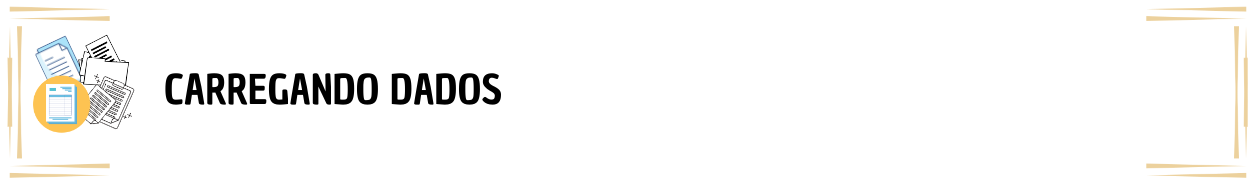

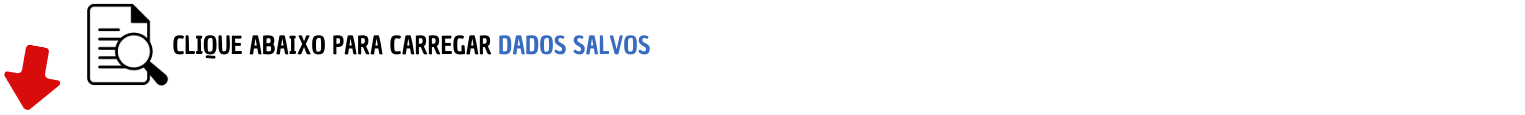

In [ ]:
# @title
import os.path
import time
from IPython.display import clear_output
from google.colab import files
from ipywidgets import interact, widgets

url_analysis = '/content/drive/MyDrive/Colab Notebooks/DataHandler/analysis'

# Lista com nomes das pastas em .../DataHandler/analysis
lista_itens = os.listdir(url_analysis)

# Contador de opções do menu
i = 1

# Lista com os números das opções do menu para verificar se alguma foi selecionada
list_opcoes = []
# Lista com os itens de cada opção (Valor da opção, Data/Hora, Comentário)
list_row = []
# Lista com as linhas da tabela de opções
list_msg = []

try:
  # Cabeçalho da tabela de opções...
  cabec = ['OPÇÃO', 'DATA/HORA', 'COMENTÁRIO']

  # Criando a lista de opções...
  for item in lista_itens:
    # Primeiro item: número da opção
    list_row.append(str(i))

    lst = item.split('|')
    lstdt = lst[0].split('-')
    dt = dtm.datetime(int(lstdt[0]), int(lstdt[1]), int(lstdt[2]))
    data = dt.strftime('%d/%m/%Y')
    hora = lst[1].split('.')

    # Segundo item: Data/Hora
    list_row.append(data + '/' + hora[0])

    # Terceiro item: Comentário
    f = open(url_analysis + '/' + item + '/coment.txt', 'r')
    list_row.append(f.read())
    f.close()

    # Adicionando os valores da opção à lista c/ linhas das mensagens
    list_msg.append(list_row)

    # Resentando lista com itens de cada opção
    list_row = []

    list_opcoes.append(item)

    i += 1
  printMessage(list_msg, cabec)
  print('\nOBS. QUALQUER VALOR DIFERENTE ENCERRA ESTA TELA\n')

  opcao = str(input('DIGITE AQUI UMA DAS OPÇÕES ACIMA E PRESSIONE "ENTER" => '))

  # Usuário selecionou um conjunto de dados salvo
  try:
    dh = DataHandler(dt=list_opcoes[int(opcao)-1])
    df_full = dh.full_df
    df_reprov = dh.reprov_df
    df_classif = dh.reprov_classif_df
    clear_output()
    print('------------------------------------------------------------------------')
    print('                     DADOS CARREGADOS COM SUCESSO')
    print('------------------------------------------------------------------------\n')
  except Exception:
    printMessage('Nenhuma opção válida foi selecionada', 'AVISO!')
  time.sleep(3)
  clear_output()
except KeyboardInterrupt:
  clear_output()
  pass

---

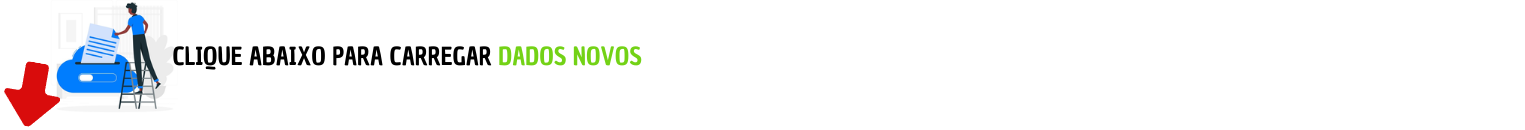

In [ ]:
# @title
from google.colab import files
from IPython.display import clear_output
import time

try:
  clear_output()
  print('------------------------------------------------------------------------------')
  print('                     SELECIONE UM PDF NO SEU COMPUTADOR')
  print('------------------------------------------------------------------------------\n')
  uploaded = files.upload()
  filename = next(iter(uploaded))
  coment = input('Digite um comentário sobre os dados e tecle ENTER (opcional):\n')
  print('------------------------------------------------------------------------------\n')
except KeyboardInterrupt:
  pass

try:
  clear_output()
  print('\n----------------------------------------------------')
  print('                     AGUARDE...')
  print('----------------------------------------------------')
  dh = DataHandler()
  dh.miningDataInPDF(filename, coment)
  df_classif = dh.classifyReprov()
  clear_output()
  print('-----------------------------------------------------')
  print('           PROCESSO CONCLUÍDO COM SUCESSO')
  print('-----------------------------------------------------')
  time.sleep(3)
  clear_output()
except KeyboardInterrupt:
  clear_output()
  pass
except Exception as e:
  clear_output()
  title = 'Um dos seguintes erros ocorreu'
  msg = ''
  msg = '- O PDF enviado é muito grande para ser processado'
  msg += '\n- O PDF enviado não possui dados no formato esperado'
  msg += '\n- O arquivo enviado não é um PDF válido'
  printMessage(msg, title)

  # Excluindo os CSVs gerados...
  try:
    main_url = DIR_PROJECT + '/analysis/' + dh.dt
    os.remove(main_url + '/coment.txt')
    os.remove(main_url + '/full_data.csv')
    os.remove(main_url + '/reprov_data.csv')
    os.rmdir(main_url)
  except Exception:
    pass

  try:
    os.remove(filename)
  except Exception:
    clear_output()
    pass

---
---

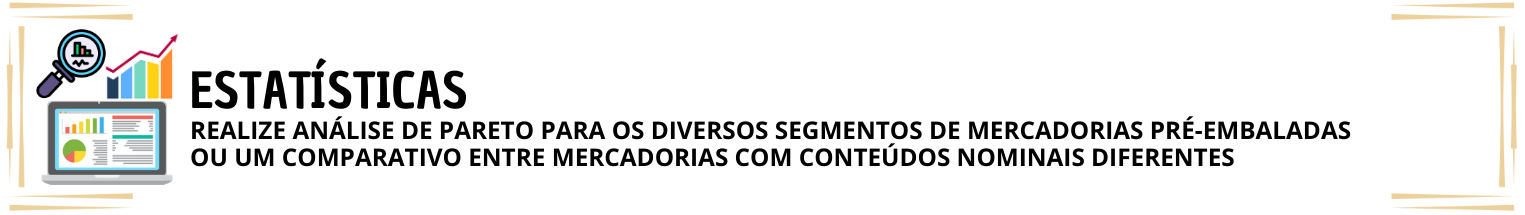
Lista de segmentos [clique aqui](https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/LISTA_SEGMENTOS.pdf)

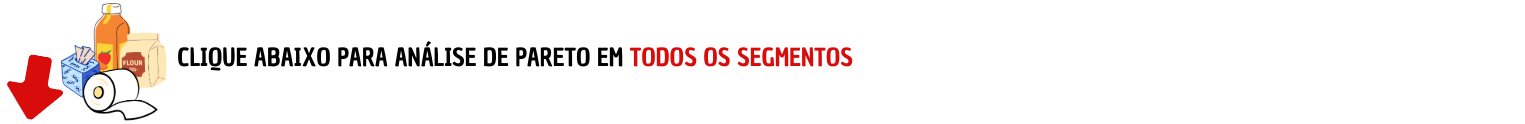

In [ ]:
# @title
try:
  df_graf1 = df_classif[df_classif['segmento'] != 'Diversos']
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf1, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto para os segmentos reprovados')
except Exception as e:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

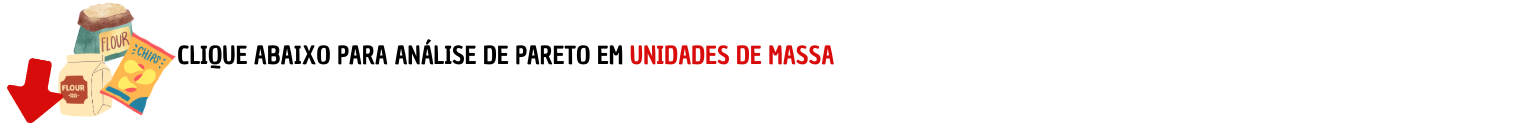

In [ ]:
#@title
try:
  df_graf2 = df_classif[df_classif['qn'].str.endswith('g')]
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf2, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em unid. de massa')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

df_classif['qn'] = df_classif['qn'].apply(lambda x: str(x))
df_graf2 = df_classif[df_classif['qn'].str.endswith('g')]

---

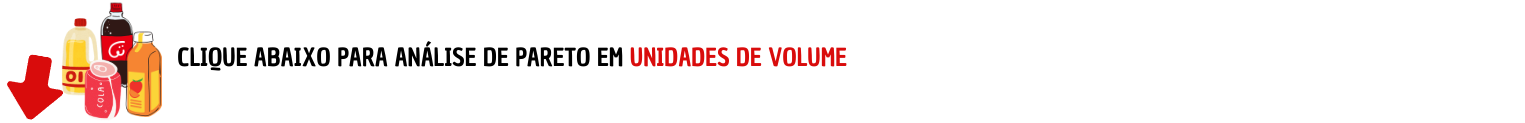

In [ ]:
# @title
try:
  df_graf3 = df_classif[df_classif['qn'].str.contains('L')]
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf3, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em unid. de volume')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

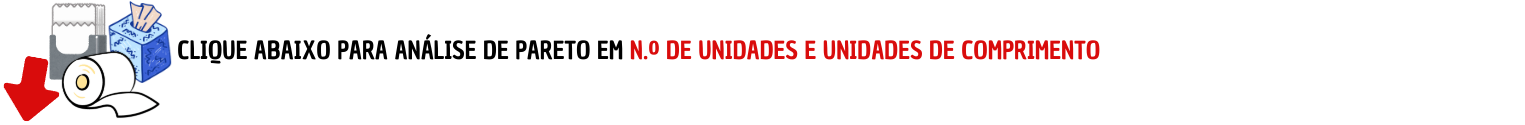

In [ ]:
# @title
try:
  df_graf4 = df_classif.query('qn.str.contains("Un") or qn.str.endswith("m")')
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf4, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em N.º unid. e unid. de comprimento')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

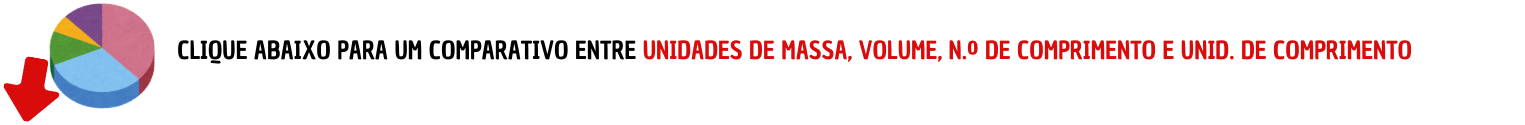

In [ ]:
# @title
try:
  rp_massa = df_classif[df_classif['qn'].str.contains('g')]
  rp_volume = df_classif[df_classif['qn'].str.contains('L')]
  rp_unid_comp = df_classif.query('qn.str.contains("Un") or qn.str.contains("m")')

  tot_mass = rp_massa.count()['quant']
  tot_vol = rp_volume.count()['quant']
  tot_unid_comp = rp_unid_comp.count()['quant']
  tot_geral = tot_mass + tot_vol + tot_unid_comp

  lst_vl = [tot_mass*100/tot_geral, tot_vol*100/tot_geral, tot_unid_comp*100/tot_geral]
  df = pd.DataFrame(lst_vl, index=['Massa', 'Volume', 'Unid. e Comprimento'], columns=['Reprov'])
  df.sort_values(by='Reprov', ascending=False, inplace=True)
  ax = df.plot(kind='bar', legend=None, title='Percentual de reprovação por tipo de produto')
  for i, v in enumerate(df['Reprov']):
      ax.text(i, v, str(round(v, 2)) + '%', ha='center', va='bottom')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---
---